# Face Signatures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import itertools
import tensorflow as tf
from IPython.display import clear_output
import PIL.Image as Image
from matplotlib.patches import Rectangle

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# Preprocessing
* The faces in the dataset have a resolution of (500 x 500)
* However, the facial keypoint detection model works on images of resolution (96 x 96)
* Here, we get the faces from the original dataset, and downsample them to work with our model

In [3]:
faces_dir = "./data/MEG_face_stim/"
faces = np.array([plt.imread(faces_dir + f) for f in os.listdir(faces_dir)])
faces_og = faces.copy()

In [4]:
mid = 250
res = 96
span = 384
half = span // 2
step = 4
output = span // step
faces = faces[:, mid - half:mid + half:step, mid - half:mid + half:step]
faces = faces.reshape(-1, output, output, 1)
print(faces.shape)

(80, 96, 96, 1)


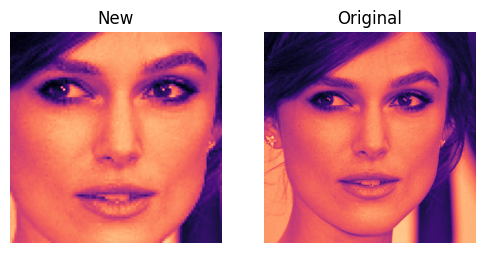

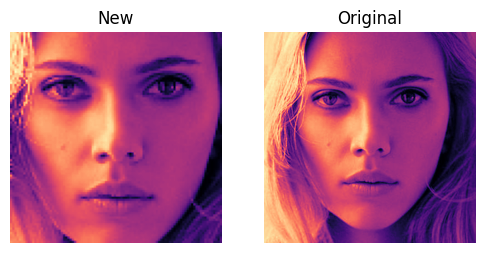

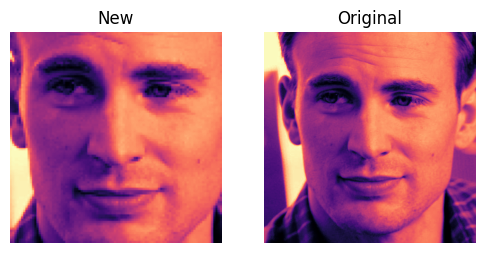

In [5]:
# visualize a few faces
# kiera knightley - 20
# scarlett johansson -28
# chris evans - 42
# hannibal lecter - 45
# robert de niro
indices = [20, 28, 61]

for i in indices:
    plt.figure(figsize=(6, 6))
    r = random.randint(0, len(faces) - 1)

    # new face
    plt.subplot(1, 2, 1)
    plt.title("New")
    plt.imshow(faces[i], cmap="magma")
    plt.axis("off")

    # original face
    plt.subplot(1, 2, 2)
    plt.title("Original")
    plt.imshow(faces_og[i], cmap="magma")
    plt.axis("off")

    plt.show()

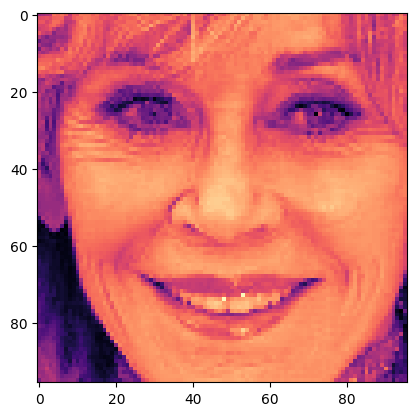

In [86]:
# see image
plt.imshow(faces[0], cmap="magma")

# GEM data

In [6]:
gem_dir = "./data/GEM/"
gem_train = pd.read_csv(gem_dir + "train.csv")
gem_test = pd.read_csv(gem_dir + "test.csv")

In [7]:
gem_train_clean = gem_train.dropna()
gem_test_clean = gem_test.dropna()

In [8]:
def get_gem_image(data):
    images = []

    # prepare the image
    for img in iter(data.loc[:, "Image"]):
        img = np.array(img.split(), dtype=float)
        img = img.reshape(96, 96, 1)
        images.append(img)
    return np.array(images)

def show_gem_image(face):
    plt.imshow(face, cmap='magma')
    plt.axis("off")
    plt.title("GEM Face")

gem_train_faces = get_gem_image(gem_train_clean)
gem_test_faces = get_gem_image(gem_test_clean)

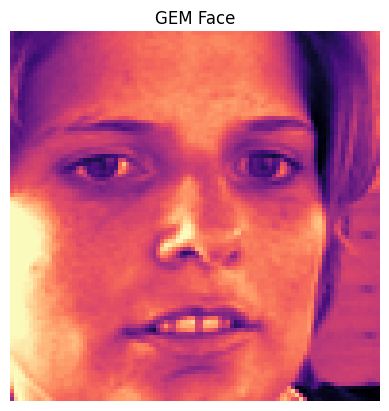

In [9]:
show_gem_image(gem_train_faces[1])
show_gem_image(gem_test_faces[6])

In [10]:
gem_train_faces.shape

(2140, 96, 96, 1)

# Load the model

In [11]:
# create a preprocessing layer
class ImageTile(tf.keras.layers.Layer):
    # def __init__(self):
    #     super().__init__(trainable=False)

    def __init__(self, **kwargs):
        super(ImageTile, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.tile(inputs, tf.constant([1, 1, 1, 3]))

In [12]:
# Load the model with the custom object
with tf.keras.utils.custom_object_scope({'ImageTile': ImageTile}):
    model = tf.keras.models.load_model("./saved/model.h5")

In [13]:
def show_images(img, feat):
    plt.imshow(img, cmap="magma")
    plt.axis("off")
    plt.scatter(feat[0::2], feat[1::2], c="r", marker="x")

def visualize_data(images, targets):
    for i in range(10):
        idx = np.random.randint(images.shape[0])
        plt.subplot(2, 5, i + 1)
        show_images(images[idx], targets[idx])
        plt.axis("off")
    plt.subplots_adjust(bottom=0.5)
    plt.show()

In [14]:
test_images = faces
test_images = tf.keras.applications.mobilenet_v2.preprocess_input(faces)
test_ds = tf.data.Dataset.from_tensor_slices((faces)).batch(64)
gem_ds = tf.data.Dataset.from_tensor_slices((gem_train_faces)).batch(64)

In [15]:
print(test_images.shape)
print(gem_train_faces.shape)

(80, 96, 96, 1)
(2140, 96, 96, 1)


In [16]:
test_preds = model.predict(test_ds)
gem_preds = model.predict(gem_ds)

34/34 [==============================] - 9s 248ms/step


In [17]:
print(test_preds.shape)
print(gem_preds.shape)

(80, 30)
(2140, 30)


In [18]:
def dissect_face(img, feat, cover_lower=False):
    # plt.imshow(img, cmap="magma")
    # plt.axis("off")
    # plt.title("Face")
    # plt.figure(figsize=(8, 8))

    # eyeliner left
    sub1 = [4, 5]
    x1 = [feat[i*2] for i in sub1]
    y1 = [feat[i*2 + 1] for i in sub1]
    y_eyeline_left = int(sum(y1) // len(y1))

    # eyeliner right
    sub2 = [2, 3]
    x2 = [feat[i*2] for i in sub2]
    y2 = [feat[i*2 + 1] for i in sub2]
    y_eyeline_right = int(sum(y2) // len(y2))

    eyeline_y = (y_eyeline_left + y_eyeline_right) / 2
    x_span1 = x1[1] - x1[0]
    x_span2 = x2[1] - x2[0]
    avg_x_span = (x_span1 + x_span2) / 2
    eye_midpoint = int((x1[0] + x2[0]) / 2)


    # plot eyeliner
    y_offset = -2.2
    eyeline_y += y_offset
    

    nose_x = int(feat[20])
    nose_y = int(feat[21])

    upper_lip_x = feat[26]
    upper_lip_y = feat[27]

    avg_nose_upper_lip_x = int((nose_x + upper_lip_x) / 2)
    avg_nose_upper_lip_y = int((nose_y + upper_lip_y) / 2)
    nose_offset = 8

    # plt.plot([midpoint, 0], [y_eyeline, y_eyeline], c="black")
    # plt.plot([midpoint, 96], [y_eyeline, y_eyeline], c="black")
    # plt.plot([midpoint, midpoint], [y_eyeline, 0], c="black")
    # plt.plot([0, 96], [avg_nose_upper_lip_y + nose_offset, avg_nose_upper_lip_y + nose_offset], c="black")

    eye_vertical_offset = 0
    eye_vertical_offset_2 = 10
    diminisher = 10
    left_eye = img[0: y_eyeline_left + eye_vertical_offset, 0:eye_midpoint]
    right_eye = img[0: y_eyeline_right + eye_vertical_offset, eye_midpoint:96 - 1]
    nose = img[y_eyeline_left:avg_nose_upper_lip_y + nose_offset, nose_x - 25: nose_x + 25]
    mouth = img[avg_nose_upper_lip_y + nose_offset:96, eye_midpoint - 25: eye_midpoint + 25]

    left_eye = np.array(left_eye)
    right_eye = np.array(right_eye)
    nose = np.array(nose)
    mouth = np.array(mouth)

    # plt.show() 
    # plt.imshow(mouth, cmap="magma")
    # plt.axis("off")
    # plt.title("Nose")
    # plt.figure(figsize=(2, 2))
    # plt.show()

    return left_eye, right_eye, nose, mouth

    # plt.scatter(feat[0::2], feat[1::2], c="black", marker="x")
    # plt.show()
    # plt.scatter(x2, y2, c="black", marker="x")

r = random.randint(0, len(test_images) - 1)
z = 28
# z = r
left_eye, right_eye, nose, mouth = dissect_face(test_images[z], test_preds[z], cover_lower=False)
# left_eye, right_eye, nose, mouth = dissect_face(gem_train_faces[z], gem_preds[z], cover_lower=False)

In [19]:
dissected_faces = []
for i in range(len(faces)):
    left_eye, right_eye, nose, mouth = dissect_face(faces[i], test_preds[i], cover_lower=False)
    dissected_faces.append(np.array([left_eye, right_eye, nose, mouth]))
dissected_faces = np.array(dissected_faces)

C:\Users\abhay\AppData\Local\Temp\ipykernel_15200\2304365626.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dissected_faces.append(np.array([left_eye, right_eye, nose, mouth]))


In [20]:
dissected_faces.shape

(80, 4)

In [21]:
y = [f[0].shape[0] for f in dissected_faces]
x = [f[0].shape[1] for f in dissected_faces]
min_left_eye_y = min(y)
min_left_eye_x = min(x)

y = [f[1].shape[0] for f in dissected_faces]
x = [f[1].shape[1] for f in dissected_faces]
min_right_eye_y = min(y)
min_right_eye_x = min(x)

y = [f[2].shape[0] for f in dissected_faces]
x = [f[2].shape[1] for f in dissected_faces]
min_nose_y = min(y)
min_nose_x = min(x)

y = [f[3].shape[0] for f in dissected_faces]
x = [f[3].shape[1] for f in dissected_faces]
min_mouth_y = min(y)
min_mouth_x = min(x)

# resize all images to the min size without cv2
for i in range(len(dissected_faces)):

    left_eye = dissected_faces[i][0]
    right_eye = dissected_faces[i][1]
    nose = dissected_faces[i][2]
    mouth = dissected_faces[i][3]

    dissected_faces[i][0] = left_eye[0:min_left_eye_y, 0:min_left_eye_x]
    dissected_faces[i][1] = right_eye[0:min_right_eye_y, 0:min_right_eye_x]
    dissected_faces[i][2] = nose[0:min_nose_y, 0:min_nose_x]
    dissected_faces[i][3] = mouth[0:min_mouth_y, 0:min_mouth_x]

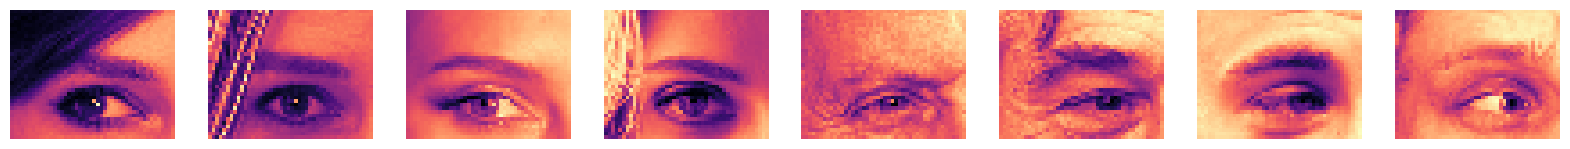

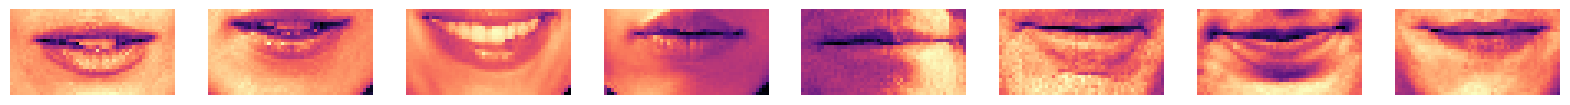

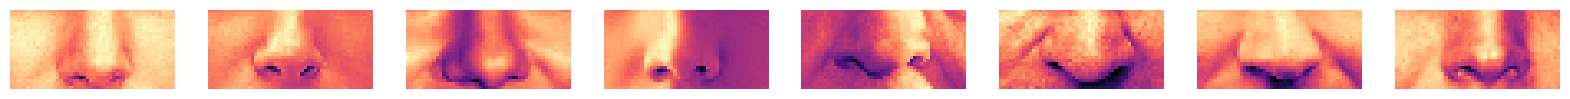

In [137]:
# plot dissected left eye, nose and mouth side by side
indices = [20, 22, 26, 28, 40, 45, 60, 75]
N = len(indices)
size = (20, 20)

# left eye
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][0], cmap="magma")
    plt.axis("off")
plt.show()

# mouth
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][3], cmap="magma")
    plt.axis("off")
plt.show()

# nose
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][2], cmap="magma")
    plt.axis("off")
plt.show()


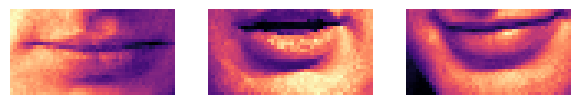

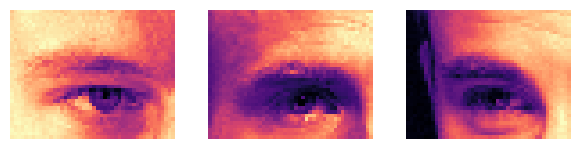

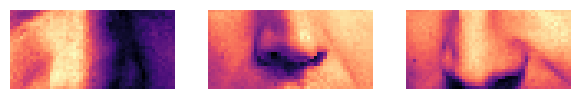

In [96]:
# left eye
indices = [20, 26, 28]
indices = [70, 62, 64]


# mouth
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][3], cmap="magma")
    plt.axis("off")
plt.show()

plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][0], cmap="magma")
    plt.axis("off")
plt.show()

# nose
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(dissected_faces[z][2], cmap="magma")
    plt.axis("off")
plt.show()

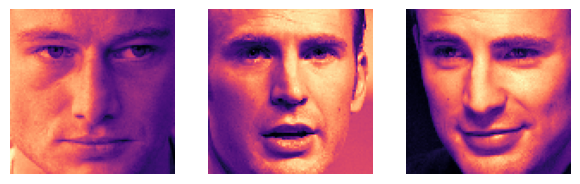

In [123]:
plt.figure(figsize=size)
for i, z in enumerate(indices):
    plt.subplot(1, N, i + 1)
    plt.imshow(faces[z], cmap="magma")
    plt.axis("off")
plt.show()

In [23]:
print(dissected_faces.shape)
print(dissected_faces[0][3].shape)

(80, 4)
(26, 50, 1)


# Target Matching Dataset - 240000
<img src="images/target-matching-task.png" width="500px">

### Faces Dataset
| Size   | 80 |
|--------|----|
| Celebs | 16 |
| Faces  | 5  |

<br>
<br>

<hr width="900px" align="left">

### Celebrity Pairs - 240
* Permutation pairs of celebrities = <sup>16</sup>P<sub>2</sub> = 240
* We take permuations because for celebrities A and B, we will be taking 2 faces from A and 1 from B
* Hence, (AB) is not the same as (BA)

### Target Matching Pairs - 100
* From every such celebrity pair, consider two sets of 5 faces each (for the 2 celebrities)
* We select 2 faces from set A and 1 from set B
* <sup>5</sup>P<sub>2</sub> <sup>5</sup>P<sub>1</sub> = 100
* Here we take permutations because each of the 2 faces from set A can take turns being the target

So there are 240 x 100 = 24000 target matching entries in total



In [24]:
NUM_FACES = 80
REPS = 5
NUM_CELEBS = 16

print(NUM_FACES)
print(REPS)
print(NUM_CELEBS)

80
5
16


In [25]:
combinations = []

# Generate all pairs of celebrities
celeb_pairs = itertools.product(range(NUM_CELEBS), repeat=2)
celeb_pairs = filter(lambda pair: pair[0] != pair[1], celeb_pairs)



for i, j in celeb_pairs:
    setA = faces[REPS * i: REPS * (i + 1)]
    setB = faces[REPS * j: REPS * (j + 1)]
    num_combinations = 50

    for comb in itertools.product(setA, setA, setB):
        # ensure that the combination is unique
        f1, f2, f3 = comb
        if np.array_equal(f1, f2):
            continue

        combinations.append(comb)

In [26]:
combinations = np.array(combinations)
print(combinations.shape)

(24000, 3, 96, 96, 1)


In [27]:
def see_face(face):
    plt.imshow(face, cmap="magma")
    plt.axis("off")
    plt.show()

def see_target_matching_combination(comb):
    target, faceA, faceB = comb[0], comb[1], comb[2]

    # randomly pick faceA or faceB as left face
    r = random.randint(0, 1)
    r = 0
    if r == 0:
        left, right = faceA, faceB
    else:
        left, right = faceB, faceA

    size = (12, 12)

    # face left
    plt.figure(figsize=size)
    plt.subplot(1, 3, 1)
    plt.imshow(left, cmap="magma")
    plt.axis("off")
    plt.title("Face A")

    # face right
    plt.subplot(1, 3, 2)
    plt.imshow(right, cmap="magma")
    plt.axis("off")
    plt.title("Face B")

    # target
    plt.subplot(1, 3, 3)
    plt.imshow(target, cmap="magma")
    plt.axis("off")
    plt.title("Target")

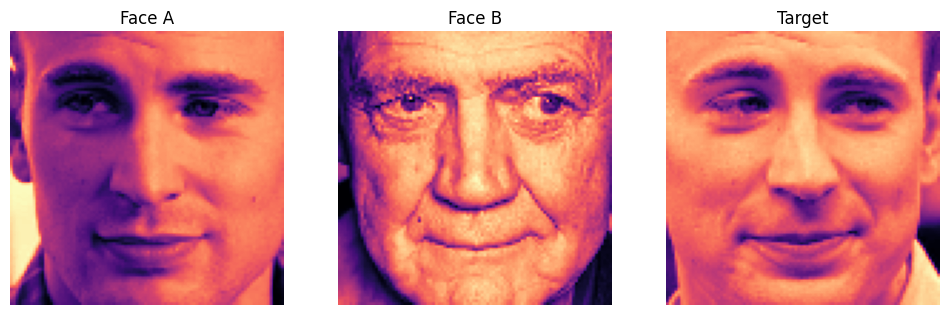

In [119]:
r = random.randint(0, len(combinations) - 1)
r = 19000
see_target_matching_combination(combinations[r])